In [1]:
# dds cloudapi for Grounding DINO 1.5
from dds_cloudapi_sdk import Config, Client, DetectionTask, TextPrompt, DetectionModel, DetectionTarget
import os
import cv2
import torch
import numpy as np
import supervision as sv
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor, build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor 
from utils.track_utils import sample_points_from_masks
from utils.video_utils import create_video_from_images
import json


In [2]:
"""
Step 1: Environment settings and model initialization for SAM 2
"""
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# init sam image predictor and video predictor model
sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

video_predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)
sam2_image_model = build_sam2(model_cfg, sam2_checkpoint)
image_predictor = SAM2ImagePredictor(sam2_image_model)

# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "notebooks/videos/pi"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# init video predictor state
inference_state = video_predictor.init_state(video_path=video_dir)

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

frame loading (JPEG): 100%|██████████| 372/372 [00:09<00:00, 41.30it/s]


## Step 2: Prompt Grounding DINO 1.5 with Cloud API for box coordinates

In [3]:
"""
Step 2: Prompt Grounding DINO 1.5 with Cloud API for box coordinates
"""
# prompt grounding dino to get the box coordinates on specific frame
img_path = os.path.join(video_dir, frame_names[ann_frame_idx])
image = Image.open(img_path)

# Step 1: initialize the config
token = "acb5ee944d3ff954cb5d2c38d1f5cab8"
config = Config(token)

# Step 2: initialize the client
client = Client(config)

In [4]:
# Step 3: run the task by DetectionTask class
# image_url = "https://algosplt.oss-cn-shenzhen.aliyuncs.com/test_files/tasks/detection/iron_man.jpg"
# if you are processing local image file, upload them to DDS server to get the image url
image_url = client.upload_file(img_path)

task = DetectionTask(
    image_url=image_url,
    prompts=[TextPrompt(text="cup.bowl.plate.chopstick.plastic bottle.spoon.fork.packet.container.foil packet.plastic container. transparent plastic packet.cardboard food container")],
    targets=[DetectionTarget.BBox],  # detect bbox
    model=DetectionModel.GDino1_5_Pro,  # detect with GroundingDino-1.5-Pro model
)

client.run_task(task)
result = task.result
objects = result.objects  # the list of detected objects

input_boxes = []
confidences = []
class_names = []

for idx, obj in enumerate(objects):
    input_boxes.append(obj.bbox)
    confidences.append(obj.score)
    class_names.append(obj.category)

input_boxes = np.array(input_boxes)

# prompt SAM image predictor to get the mask for the object
image_predictor.set_image(np.array(image.convert("RGB")))

# process the detection results
OBJECTS = class_names

ID_TO_OBJECTS = {i+1: obj for i, obj in enumerate(OBJECTS)}

# prompt SAM 2 image predictor to get the mask for the object
masks, scores, logits = image_predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

# convert the mask shape to (n, H, W)
if masks.ndim == 3:
    masks = masks[None]
    scores = scores[None]
    logits = logits[None]
elif masks.ndim == 4:
    masks = masks.squeeze(1)

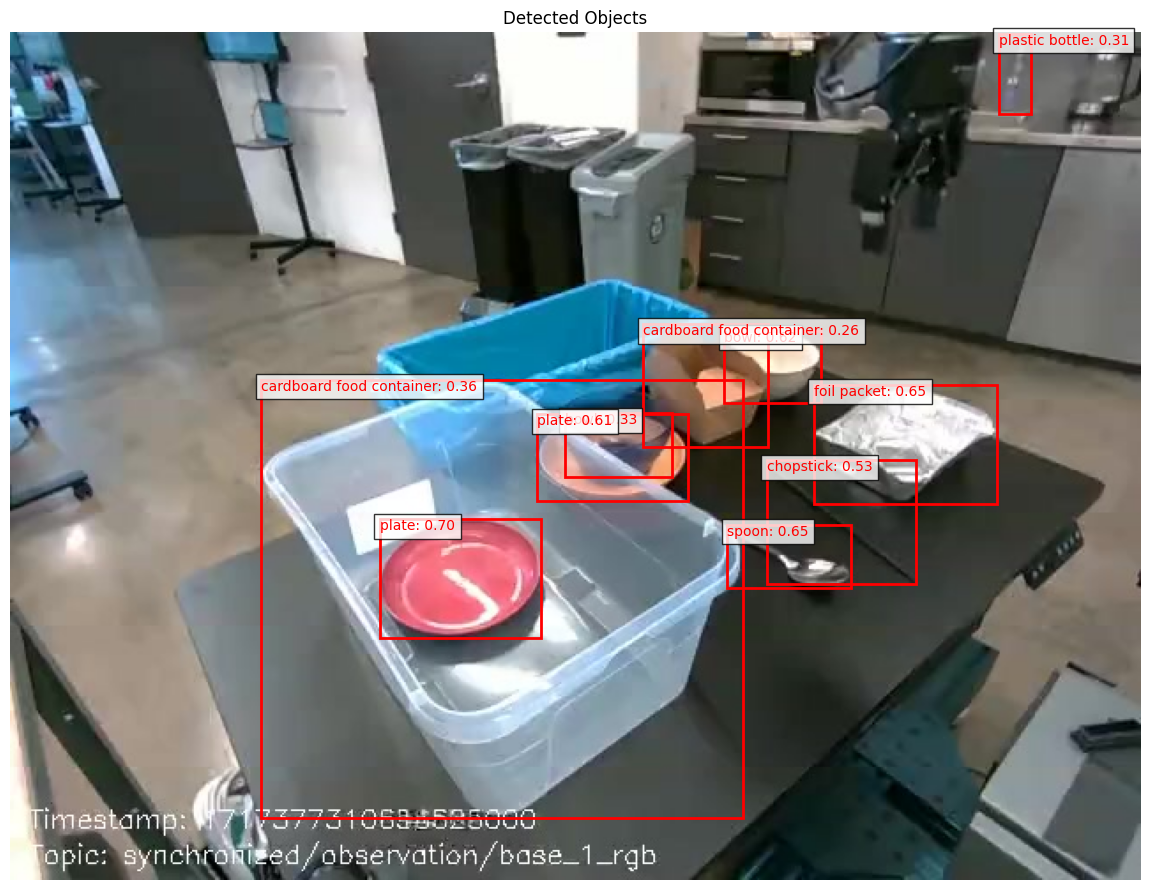

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def plot_image_with_boxes(image_path, boxes, class_names, confidences):
    # Load the image
    image = Image.open(image_path)
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    # Display the image
    ax.imshow(image)
    
    # Create a Rectangle patch for each box
    for box, class_name, confidence in zip(boxes, class_names, confidences):
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add label
        ax.text(x, y, f'{class_name}: {confidence:.2f}', 
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='top', color='red')

    plt.axis('off')
    plt.title('Detected Objects')
    plt.tight_layout()
    plt.show()

# Assuming you have the following variables from your previous code:
# img_path: path to your image
# input_boxes: numpy array of bounding boxes
# class_names: list of class names for each detected object
# confidences: list of confidence scores for each detected object

# Convert input_boxes to the format [x, y, width, height]
boxes_for_plot = []
for box in input_boxes:
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1
    boxes_for_plot.append([x1, y1, width, height])

# Plot the image with bounding boxes
plot_image_with_boxes(img_path, boxes_for_plot, class_names, confidences)

Shape of masks: (10, 480, 640)
Data type: float32
Number of non-zero elements: 52393


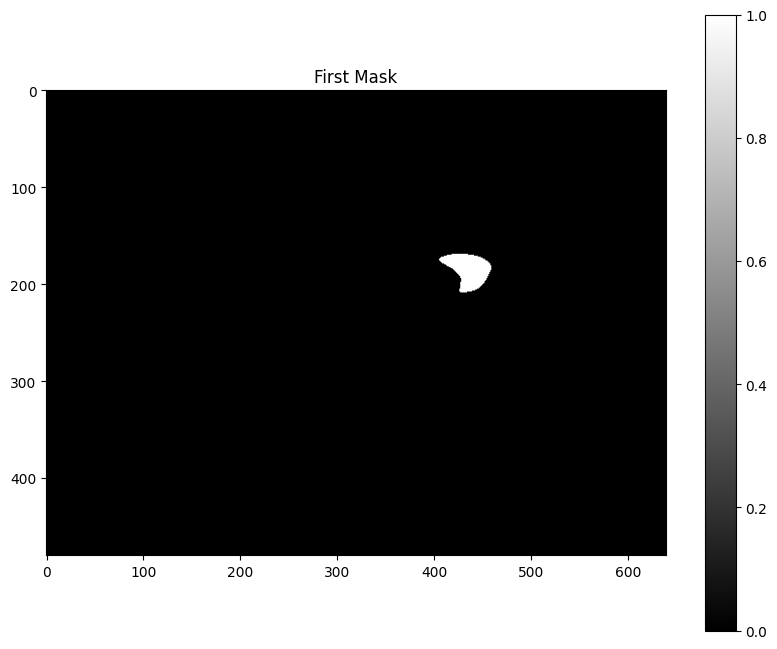

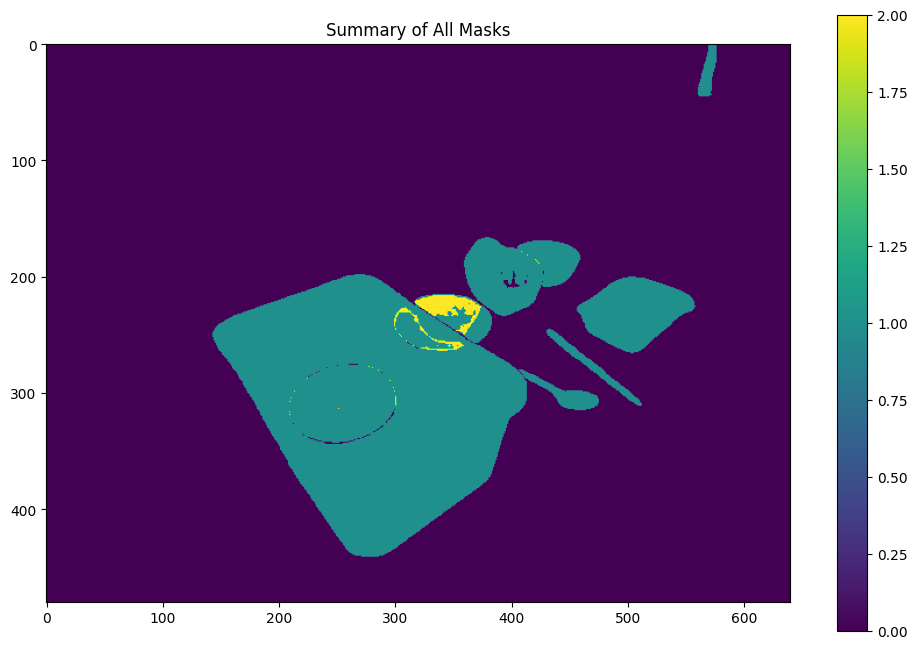

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'masks' is your variable with shape (16, 480, 640)
print(f"Shape of masks: {masks.shape}")
print(f"Data type: {masks.dtype}")
print(f"Number of non-zero elements: {np.count_nonzero(masks)}")

# Visualize a single mask
def plot_mask(mask, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

# Plot the first mask
plot_mask(masks[0], "First Mask")

# Plot a summary of all masks
plt.figure(figsize=(12, 8))
plt.imshow(np.sum(masks, axis=0), cmap='viridis')
plt.title("Summary of All Masks")
plt.colorbar()
plt.show()

# # Print statistics for each mask
# for i in range(masks.shape[0]):
#     mask = masks[i]
#     print(f"Mask {i}:")
#     print(f"  Min: {mask.min():.4f}, Max: {mask.max():.4f}")
#     print(f"  Mean: {mask.mean():.4f}, Std: {mask.std():.4f}")
#     print(f"  Non-zero pixels: {np.count_nonzero(mask)}")
#     print()

## Step 3: Register each object's positive points to video predictor with separate add_new_points call

In [7]:
PROMPT_TYPE_FOR_VIDEO = "box"  # or "point" or "mask"

assert PROMPT_TYPE_FOR_VIDEO in ["point", "box", "mask"], "SAM 2 video predictor only support point/box/mask prompt"

# If you are using point prompts, we uniformly sample positive points based on the mask
if PROMPT_TYPE_FOR_VIDEO == "point":
    # sample the positive points from mask for each objects
    all_sample_points = sample_points_from_masks(masks=masks, num_points=10)
    for object_id, (label, points) in enumerate(zip(OBJECTS, all_sample_points), start=1):
        labels = np.ones((points.shape[0]), dtype=np.int32)
        _, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=object_id,
            points=points,
            labels=labels,
        )
# Using box prompt
elif PROMPT_TYPE_FOR_VIDEO == "box":
    for object_id, (label, box) in enumerate(zip(OBJECTS, input_boxes), start=1):
        _, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=object_id,
            box=box,
        )
# Using mask prompt is a more straightforward way
elif PROMPT_TYPE_FOR_VIDEO == "mask":
    for object_id, (label, mask) in enumerate(zip(OBJECTS, masks), start=1):
        labels = np.ones((1), dtype=np.int32)
        _, out_obj_ids, out_mask_logits = video_predictor.add_new_mask(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=object_id,
            mask=mask
        )
else:
    raise NotImplementedError("SAM 2 video predictor only support point/box/mask prompts")

## Step 4: Propagate the video predictor to get the segmentation results for each frame

In [8]:
def get_mask_coordinates(mask):
    return np.column_stack(np.where(mask))

video_segments = {}  # video_segments contains the per-frame segmentation results
mask_coordinates = {}  # To store mask coordinates for each frame and object
for out_frame_idx, out_obj_ids, out_mask_logits in video_predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
    
    # Extract and store coordinates
    mask_coordinates[out_frame_idx] = {
        out_obj_id: get_mask_coordinates(video_segments[out_frame_idx][out_obj_id])
        for out_obj_id in out_obj_ids
    }

# Save mask coordinates to a file
with open('mask_coordinates.json', 'w') as f:
    json.dump({str(k): {str(k2): v2.tolist() for k2, v2 in v.items()} 
               for k, v in mask_coordinates.items()}, f)

propagate in video:   0%|          | 0/372 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 372/372 [00:40<00:00,  9.19it/s]


## Step 5: Detect object movement and track significant movements


In [72]:
def calculate_distances(x_coords, y_coords):
    distances = np.sqrt(np.diff(x_coords)**2 + np.diff(y_coords)**2)
    return np.insert(distances, 0, 0)  # Add 0 at the beginning for the first frame


def find_movement_frames(x_coords, y_coords):
    distances = calculate_distances(x_coords, y_coords)
    start_frame = None
    end_frame = None
    count_large_movements = 0
    count_small_movements = 0
    last_reset_frame = -1
    
    for idx, distance in enumerate(distances):
        if distance > 5:
            if start_frame is None and idx > last_reset_frame:
                # Find the last distance < 1 before this point, but after the last reset
                for i in range(idx-1, last_reset_frame, -1):
                    if distances[i] < 1:
                        start_frame = i
                        break
                if start_frame is None:
                    start_frame = last_reset_frame + 1  # If no small movement found, set to frame after last reset
            
            count_large_movements += 1
            count_small_movements = 0
        elif distance < 1:
            count_small_movements += 1
            if count_small_movements == 2:
                if count_large_movements >= 5:
                    end_frame = idx - 1  # First frame of the two small movements
                    break
                else:
                    count_large_movements = 0
                    count_small_movements = 0
                    start_frame = None
                    last_reset_frame = idx
        else:
            count_small_movements = 0
    
    print(count_large_movements)
    # If we haven't found at least 5 large movements, reset end_frame to None
    if count_large_movements < 5:
        end_frame = None
    
    return start_frame, end_frame, distances

Structure of coordinates for frame 0, object 1:
[[  0 169 418]
 [  0 169 419]
 [  0 169 420]
 ...
 [  0 208 432]
 [  0 208 433]
 [  0 208 434]]
Shape: (1277, 3)


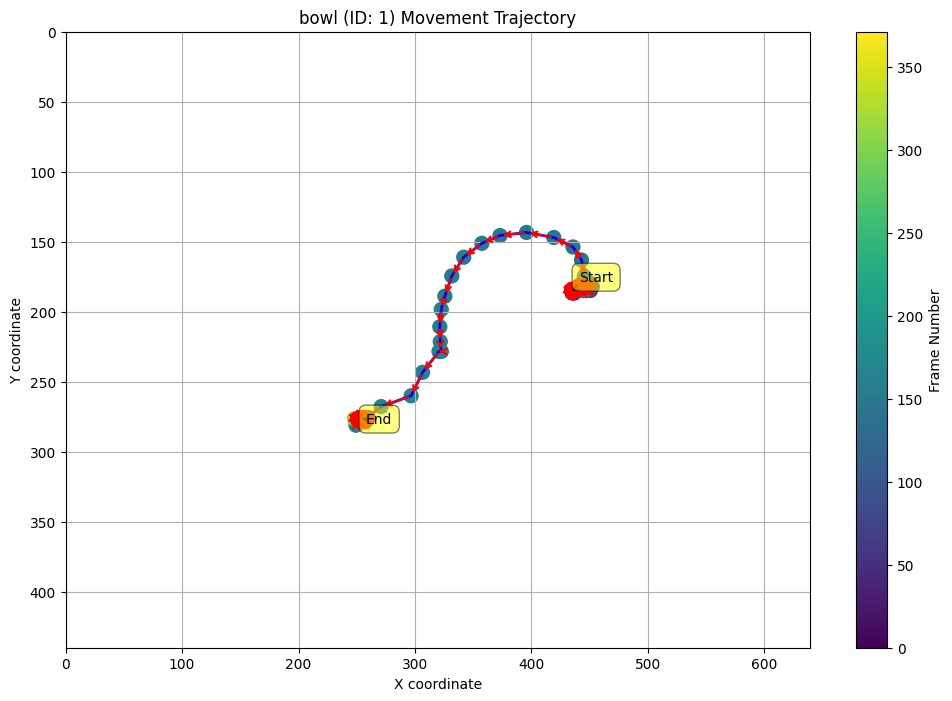

Movement detected from frame 145 to frame 371

Movement summary for Object 1:
From frame 0 to 1: Moved 0.11 pixels
  Primarily rightward movement
From frame 1 to 2: Moved 0.25 pixels
  Primarily upward movement
From frame 2 to 3: Moved 0.23 pixels
  Primarily leftward movement
From frame 3 to 4: Moved 0.03 pixels
  Primarily rightward movement
From frame 4 to 5: Moved 0.03 pixels
  Primarily leftward movement
From frame 5 to 6: Moved 0.06 pixels
  Primarily downward movement
From frame 6 to 7: Moved 0.04 pixels
  Primarily rightward movement
From frame 7 to 8: Moved 0.03 pixels
  Primarily downward movement
From frame 8 to 9: Moved 0.13 pixels
  Primarily upward movement
From frame 9 to 10: Moved 0.21 pixels
  Primarily downward movement
From frame 10 to 11: Moved 0.72 pixels
  Primarily downward movement
From frame 11 to 12: Moved 1.19 pixels
  Primarily rightward movement
From frame 12 to 13: Moved 0.92 pixels
  Primarily rightward movement
From frame 13 to 14: Moved 1.65 pixels
  Pr

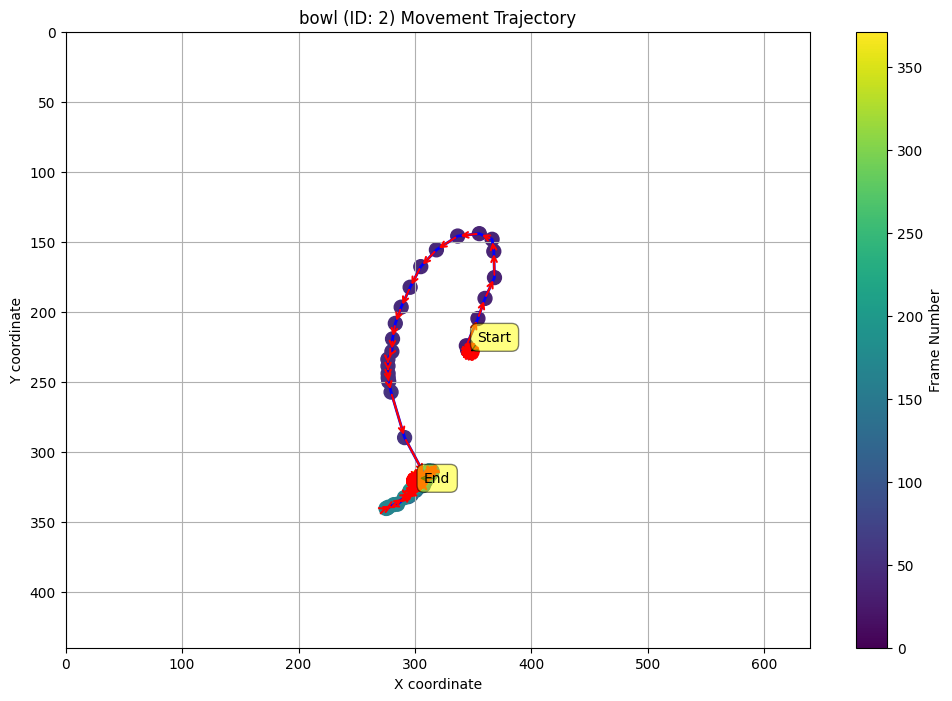

Movement detected from frame 32 to frame 371

Movement summary for Object 2:
From frame 0 to 1: Moved 0.00 pixels
  Primarily rightward movement
From frame 1 to 2: Moved 0.31 pixels
  Primarily leftward movement
From frame 2 to 3: Moved 0.27 pixels
  Primarily rightward movement
From frame 3 to 4: Moved 0.35 pixels
  Primarily leftward movement
From frame 4 to 5: Moved 0.02 pixels
  Primarily leftward movement
From frame 5 to 6: Moved 0.02 pixels
  Primarily leftward movement
From frame 6 to 7: Moved 0.02 pixels
  Primarily upward movement
From frame 7 to 8: Moved 0.06 pixels
  Primarily downward movement
From frame 8 to 9: Moved 0.02 pixels
  Primarily leftward movement
From frame 9 to 10: Moved 0.02 pixels
  Primarily rightward movement
From frame 10 to 11: Moved 0.09 pixels
  Primarily rightward movement
From frame 11 to 12: Moved 0.01 pixels
  Primarily leftward movement
From frame 12 to 13: Moved 0.03 pixels
  Primarily rightward movement
From frame 13 to 14: Moved 0.04 pixels
  P

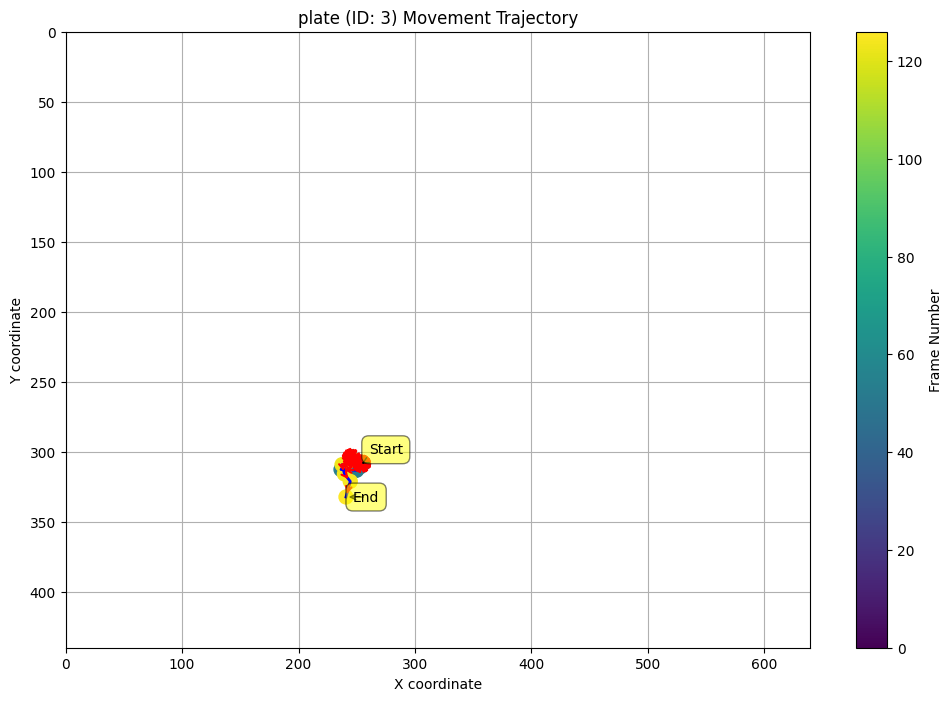

No significant movement detected

Movement summary for Object 3:
From frame 0 to 1: Moved 0.06 pixels
  Primarily upward movement
From frame 1 to 2: Moved 0.24 pixels
  Primarily downward movement
From frame 2 to 3: Moved 0.01 pixels
  Primarily leftward movement
From frame 3 to 4: Moved 0.04 pixels
  Primarily downward movement
From frame 4 to 5: Moved 0.02 pixels
  Primarily leftward movement
From frame 5 to 6: Moved 0.03 pixels
  Primarily leftward movement
From frame 6 to 7: Moved 0.05 pixels
  Primarily rightward movement
From frame 7 to 8: Moved 0.05 pixels
  Primarily leftward movement
From frame 8 to 9: Moved 0.01 pixels
  Primarily downward movement
From frame 9 to 10: Moved 0.03 pixels
  Primarily rightward movement
From frame 10 to 11: Moved 0.44 pixels
  Primarily leftward movement
From frame 11 to 12: Moved 0.03 pixels
  Primarily leftward movement
From frame 12 to 13: Moved 0.01 pixels
  Primarily leftward movement
From frame 13 to 14: Moved 0.24 pixels
  Primarily rightw

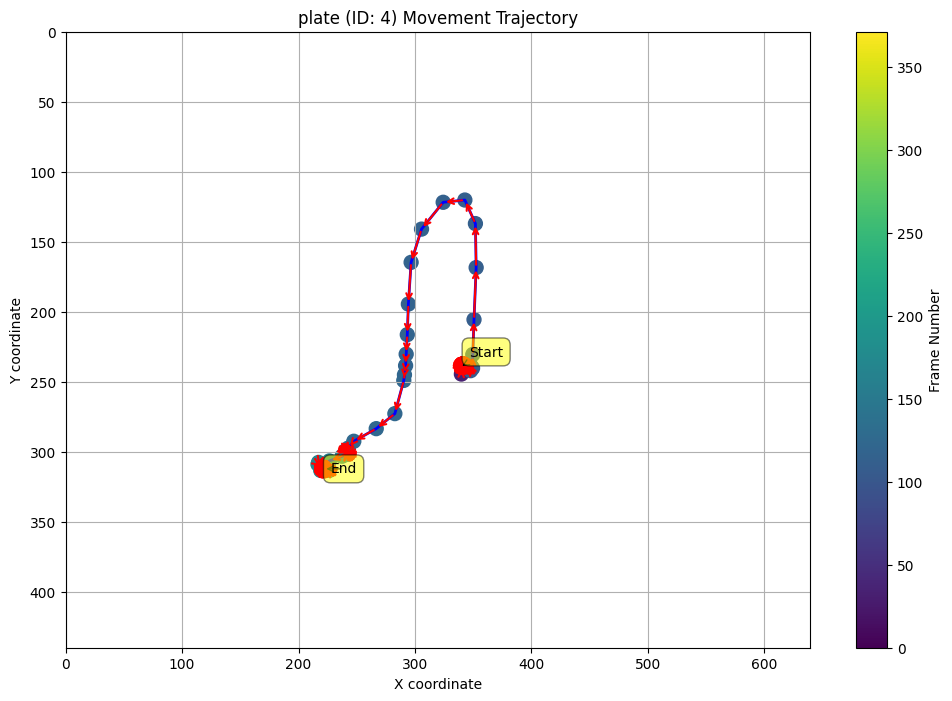

Movement detected from frame 107 to frame 371

Movement summary for Object 4:
From frame 0 to 1: Moved 1.07 pixels
  Primarily rightward movement
From frame 1 to 2: Moved 0.36 pixels
  Primarily leftward movement
From frame 2 to 3: Moved 0.03 pixels
  Primarily downward movement
From frame 3 to 4: Moved 0.12 pixels
  Primarily rightward movement
From frame 4 to 5: Moved 0.12 pixels
  Primarily downward movement
From frame 5 to 6: Moved 0.13 pixels
  Primarily leftward movement
From frame 6 to 7: Moved 0.05 pixels
  Primarily downward movement
From frame 7 to 8: Moved 0.05 pixels
  Primarily leftward movement
From frame 8 to 9: Moved 0.02 pixels
  Primarily downward movement
From frame 9 to 10: Moved 0.13 pixels
  Primarily leftward movement
From frame 10 to 11: Moved 0.27 pixels
  Primarily upward movement
From frame 11 to 12: Moved 0.10 pixels
  Primarily downward movement
From frame 12 to 13: Moved 0.06 pixels
  Primarily rightward movement
From frame 13 to 14: Moved 0.10 pixels
  Pr

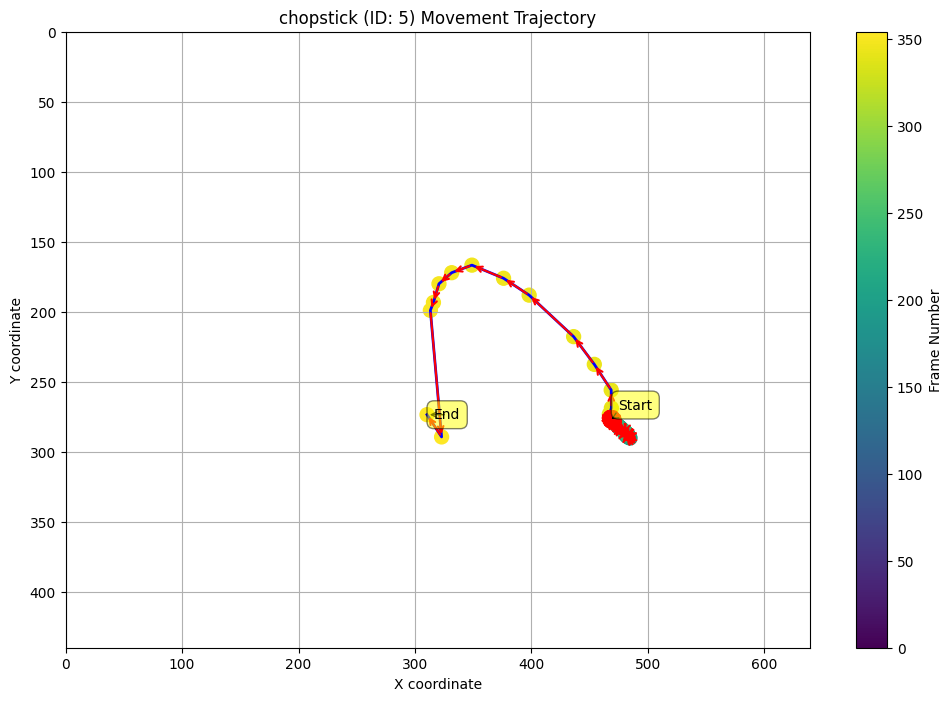

Movement detected from frame 339 to frame 353

Movement summary for Object 5:
From frame 0 to 1: Moved 0.37 pixels
  Primarily downward movement
From frame 1 to 2: Moved 0.61 pixels
  Primarily rightward movement
From frame 2 to 3: Moved 0.10 pixels
  Primarily leftward movement
From frame 3 to 4: Moved 0.13 pixels
  Primarily leftward movement
From frame 4 to 5: Moved 0.09 pixels
  Primarily downward movement
From frame 5 to 6: Moved 0.22 pixels
  Primarily upward movement
From frame 6 to 7: Moved 0.06 pixels
  Primarily rightward movement
From frame 7 to 8: Moved 0.11 pixels
  Primarily leftward movement
From frame 8 to 9: Moved 0.12 pixels
  Primarily rightward movement
From frame 9 to 10: Moved 0.11 pixels
  Primarily leftward movement
From frame 10 to 11: Moved 0.07 pixels
  Primarily rightward movement
From frame 11 to 12: Moved 0.05 pixels
  Primarily rightward movement
From frame 12 to 13: Moved 0.10 pixels
  Primarily upward movement
From frame 13 to 14: Moved 0.10 pixels
  Pr

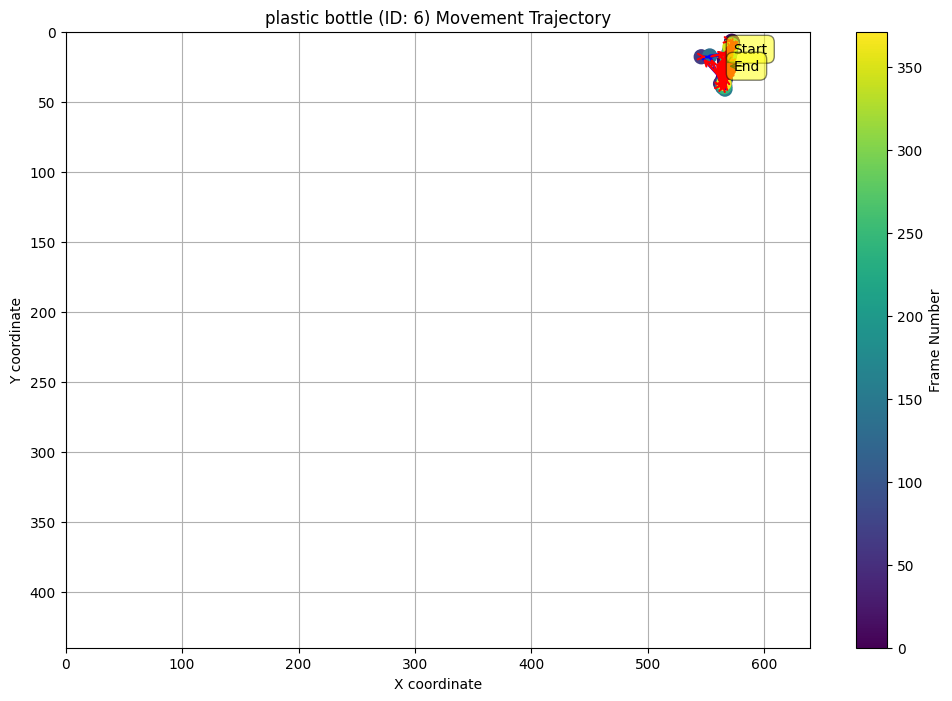

No significant movement detected

Movement summary for Object 6:
From frame 0 to 1: Moved 0.48 pixels
  Primarily upward movement
From frame 1 to 2: Moved 0.99 pixels
  Primarily upward movement
From frame 2 to 3: Moved 0.76 pixels
  Primarily upward movement
From frame 3 to 4: Moved 0.17 pixels
  Primarily leftward movement
From frame 4 to 5: Moved 0.49 pixels
  Primarily upward movement
From frame 5 to 6: Moved 1.31 pixels
  Primarily downward movement
From frame 6 to 7: Moved 0.07 pixels
  Primarily upward movement
From frame 7 to 8: Moved 12.46 pixels
  Primarily downward movement
From frame 8 to 14: Moved 27.45 pixels
  Primarily upward movement
From frame 14 to 15: Moved 0.93 pixels
  Primarily leftward movement
From frame 15 to 16: Moved 0.23 pixels
  Primarily rightward movement
From frame 16 to 36: Moved 31.69 pixels
  Primarily downward movement
From frame 36 to 37: Moved 5.77 pixels
  Primarily upward movement
From frame 37 to 38: Moved 5.05 pixels
  Primarily upward movemen

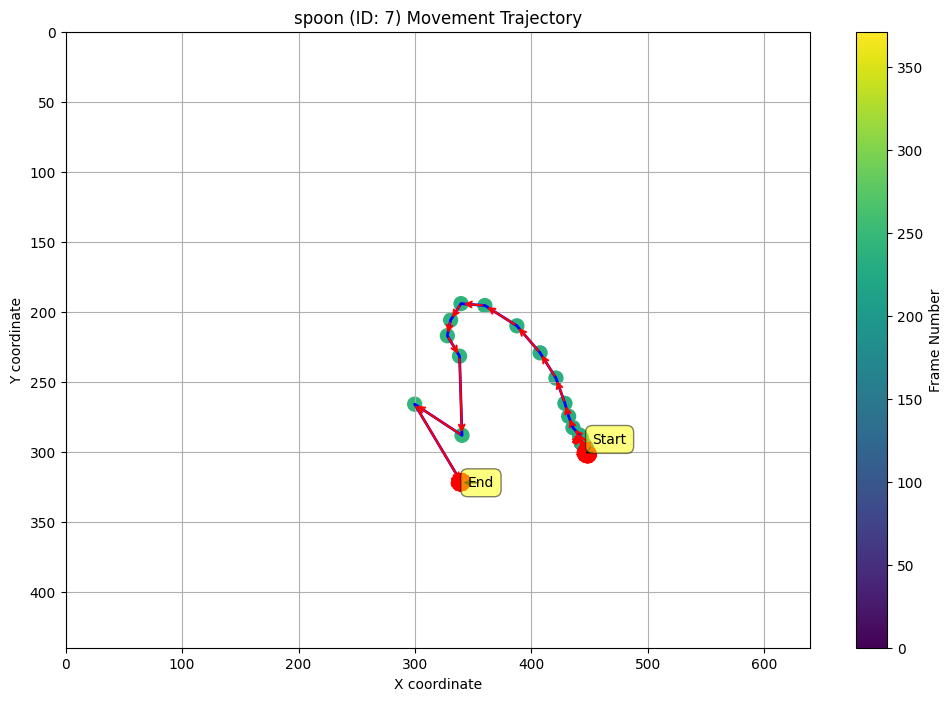

Movement detected from frame 230 to frame 371

Movement summary for Object 7:
From frame 0 to 1: Moved 0.06 pixels
  Primarily leftward movement
From frame 1 to 2: Moved 0.03 pixels
  Primarily leftward movement
From frame 2 to 3: Moved 0.01 pixels
  Primarily upward movement
From frame 3 to 4: Moved 0.06 pixels
  Primarily rightward movement
From frame 4 to 5: Moved 0.06 pixels
  Primarily leftward movement
From frame 5 to 6: Moved 0.30 pixels
  Primarily rightward movement
From frame 6 to 7: Moved 0.10 pixels
  Primarily upward movement
From frame 7 to 8: Moved 0.03 pixels
  Primarily rightward movement
From frame 8 to 9: Moved 0.03 pixels
  Primarily upward movement
From frame 9 to 10: Moved 0.06 pixels
  Primarily upward movement
From frame 10 to 11: Moved 0.08 pixels
  Primarily rightward movement
From frame 11 to 12: Moved 0.10 pixels
  Primarily rightward movement
From frame 12 to 13: Moved 0.11 pixels
  Primarily leftward movement
From frame 13 to 14: Moved 0.11 pixels
  Primar

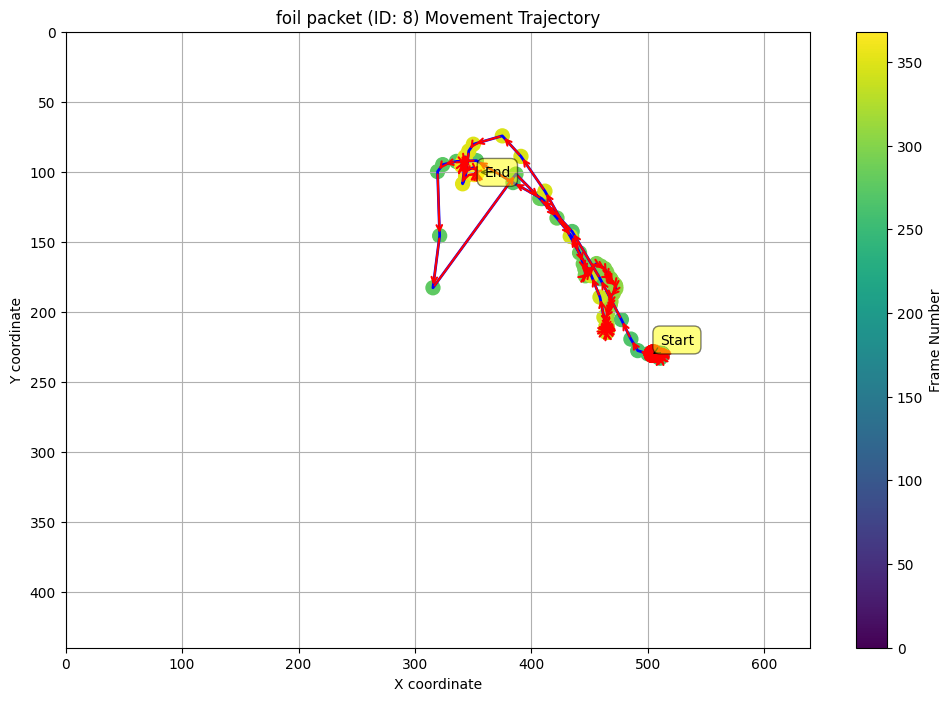

Movement detected from frame 261 to frame 364

Movement summary for Object 8:
From frame 0 to 1: Moved 0.25 pixels
  Primarily upward movement
From frame 1 to 2: Moved 0.02 pixels
  Primarily downward movement
From frame 2 to 3: Moved 0.02 pixels
  Primarily upward movement
From frame 3 to 4: Moved 0.02 pixels
  Primarily rightward movement
From frame 4 to 5: Moved 0.02 pixels
  Primarily upward movement
From frame 5 to 6: Moved 0.07 pixels
  Primarily rightward movement
From frame 6 to 7: Moved 0.02 pixels
  Primarily leftward movement
From frame 7 to 8: Moved 0.01 pixels
  Primarily downward movement
From frame 8 to 9: Moved 0.01 pixels
  Primarily leftward movement
From frame 9 to 10: Moved 0.01 pixels
  Primarily upward movement
From frame 10 to 11: Moved 0.08 pixels
  Primarily leftward movement
From frame 11 to 12: Moved 0.07 pixels
  Primarily leftward movement
From frame 12 to 13: Moved 0.03 pixels
  Primarily rightward movement
From frame 13 to 14: Moved 0.05 pixels
  Primaril

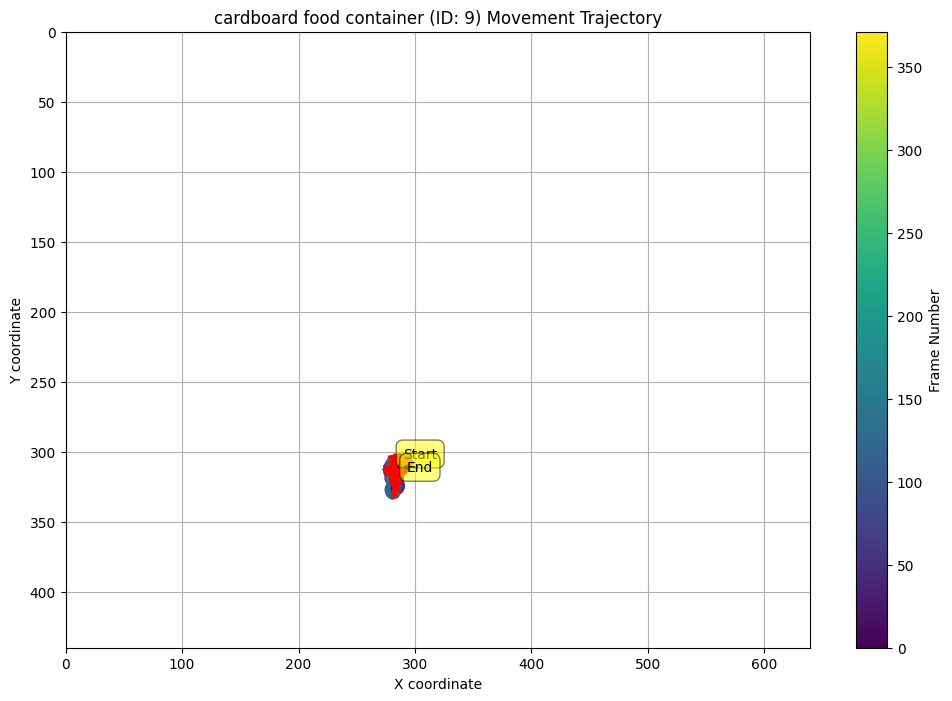

No significant movement detected

Movement summary for Object 9:
From frame 0 to 1: Moved 0.07 pixels
  Primarily upward movement
From frame 1 to 2: Moved 0.18 pixels
  Primarily rightward movement
From frame 2 to 3: Moved 0.02 pixels
  Primarily downward movement
From frame 3 to 4: Moved 0.14 pixels
  Primarily downward movement
From frame 4 to 5: Moved 0.04 pixels
  Primarily leftward movement
From frame 5 to 6: Moved 0.07 pixels
  Primarily rightward movement
From frame 6 to 7: Moved 0.19 pixels
  Primarily upward movement
From frame 7 to 8: Moved 0.17 pixels
  Primarily downward movement
From frame 8 to 9: Moved 0.04 pixels
  Primarily downward movement
From frame 9 to 10: Moved 0.17 pixels
  Primarily upward movement
From frame 10 to 11: Moved 0.03 pixels
  Primarily upward movement
From frame 11 to 12: Moved 0.23 pixels
  Primarily downward movement
From frame 12 to 13: Moved 0.06 pixels
  Primarily upward movement
From frame 13 to 14: Moved 0.03 pixels
  Primarily downward movem

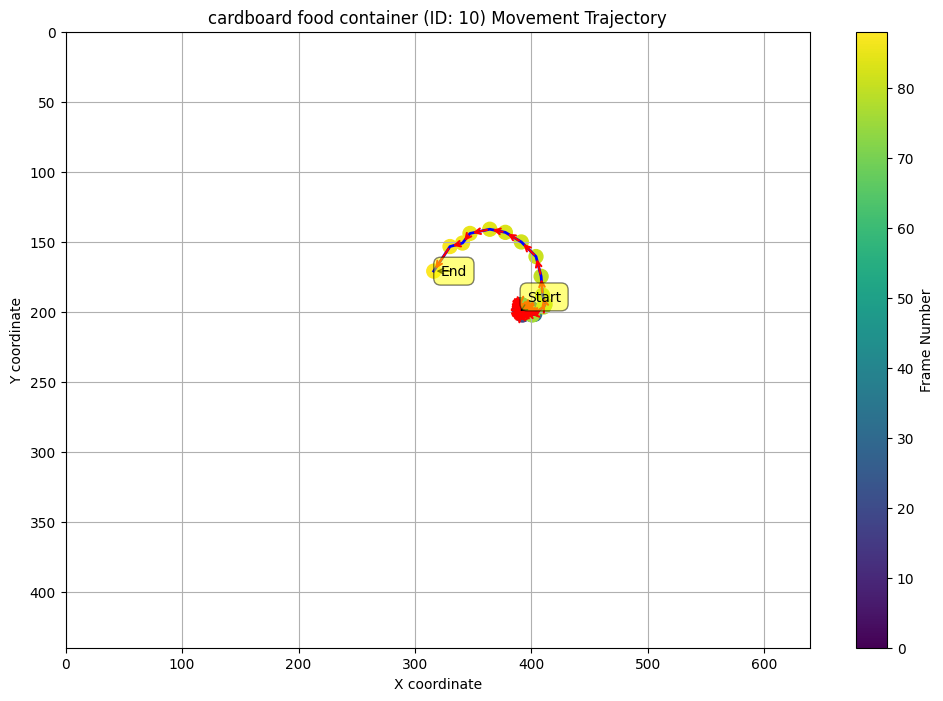

Movement detected from frame 77 to frame 88

Movement summary for Object 10:
From frame 0 to 1: Moved 0.20 pixels
  Primarily downward movement
From frame 1 to 2: Moved 0.12 pixels
  Primarily leftward movement
From frame 2 to 3: Moved 0.03 pixels
  Primarily upward movement
From frame 3 to 4: Moved 0.03 pixels
  Primarily rightward movement
From frame 4 to 5: Moved 0.04 pixels
  Primarily upward movement
From frame 5 to 6: Moved 0.02 pixels
  Primarily upward movement
From frame 6 to 7: Moved 0.08 pixels
  Primarily rightward movement
From frame 7 to 8: Moved 0.04 pixels
  Primarily upward movement
From frame 8 to 9: Moved 0.02 pixels
  Primarily rightward movement
From frame 9 to 10: Moved 0.03 pixels
  Primarily leftward movement
From frame 10 to 11: Moved 0.04 pixels
  Primarily upward movement
From frame 11 to 12: Moved 0.11 pixels
  Primarily rightward movement
From frame 12 to 13: Moved 0.81 pixels
  Primarily leftward movement
From frame 13 to 14: Moved 0.32 pixels
  Primarily 

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import json

# Load the mask coordinates
with open('mask_coordinates.json', 'r') as f:
    mask_coordinates = json.load(f)

# Convert string keys to integers
mask_coordinates = {int(k): {int(k2): np.array(v2) for k2, v2 in v.items()} 
                    for k, v in mask_coordinates.items()}

# Get unique object IDs
object_ids = set(obj_id for frame in mask_coordinates.values() for obj_id in frame)

# Debug: Print structure of mask_coordinates for the first frame and object
first_frame = min(mask_coordinates.keys())
first_obj = min(mask_coordinates[first_frame].keys())
print(f"Structure of coordinates for frame {first_frame}, object {first_obj}:")
print(mask_coordinates[first_frame][first_obj])
print(f"Shape: {mask_coordinates[first_frame][first_obj].shape}")


def get_centroid(coords):
    """Calculate the centroid of the coordinates."""
    if coords.size == 0:  # Handle empty array
        return None
    if coords.ndim == 1:  # Handle 1D array
        return coords[1:] if len(coords) > 2 else None
    return np.mean(coords[:, 1:], axis=0)  # For 2D array, ignore the first column (always 0)

# Determine the original image dimensions
max_y = max_x = 0
for frame in mask_coordinates.values():
    for obj in frame.values():
        if obj.size == 0:  # Skip empty arrays
            continue
        if obj.ndim == 1:
            if len(obj) > 2:
                max_y = max(max_y, obj[1])
                max_x = max(max_x, obj[2])
        else:
            max_y = max(max_y, np.max(obj[:, 1]))
            max_x = max(max_x, np.max(obj[:, 2]))

# Dictionary to map object IDs to names (you can modify this as needed)
object_names = {i: f"Object {i}" for i in object_ids}

for obj_id in object_ids:
    object_coords = {}
    for frame in sorted(mask_coordinates.keys()):
        if obj_id in mask_coordinates[frame]:
            centroid = get_centroid(mask_coordinates[frame][obj_id])
            if centroid is not None:
                object_coords[frame] = centroid

    if not object_coords:
        print(f"No valid coordinates for Object {obj_id}")
        continue

    # Extract x and y coordinates
    frames = list(object_coords.keys())
    y_coords = [coord[0] for coord in object_coords.values()]
    x_coords = [coord[1] for coord in object_coords.values()]

    plt.figure(figsize=(12, 8))
    
    # Plot trajectory
    plt.plot(x_coords, y_coords, 'b-', linewidth=2)
    plt.scatter(x_coords, y_coords, c=frames, cmap='viridis', s=100)
    
    # Add arrows to show direction
    for i in range(1, len(frames)):
        plt.annotate('', xy=(x_coords[i], y_coords[i]), xytext=(x_coords[i-1], y_coords[i-1]),
                     arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    
    # Annotate start and end points
    plt.annotate('Start', xy=(x_coords[0], y_coords[0]), xytext=(5, 5), 
                 textcoords='offset points', ha='left', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.annotate('End', xy=(x_coords[-1], y_coords[-1]), xytext=(5, 5), 
                 textcoords='offset points', ha='left', va='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    plt.colorbar(label='Frame Number')
    plt.title(f'{ID_TO_OBJECTS.get(obj_id, f"Unknown Object")} (ID: {obj_id}) Movement Trajectory')    
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.xlim(0, max_x)
    plt.ylim(max_y, 0)  # Invert y-axis to match image coordinates
    plt.grid(True)
    plt.show()
    
    # Assuming you have lists: x_coords, y_coords
    start_frame, end_frame, distances = find_movement_frames(x_coords, y_coords)

    if start_frame is not None and end_frame is not None:
        print(f"Movement detected from frame {start_frame} to frame {end_frame}")
    else:
        print("No significant movement detected")

    print(f"\nMovement summary for Object {obj_id}:")
    for i in range(1, len(frames)):
        dx = x_coords[i] - x_coords[i-1]
        dy = y_coords[i] - y_coords[i-1]
        distance = np.sqrt(dx**2 + dy**2)
        print(f"From frame {frames[i-1]} to {frames[i]}: Moved {distance:.2f} pixels")
        if abs(dx) > abs(dy):
            print(f"  Primarily {'rightward' if dx > 0 else 'leftward'} movement")
        else:
            print(f"  Primarily {'downward' if dy > 0 else 'upward'} movement")

    # Calculate total distance moved
    total_distance = np.sum([np.sqrt((x_coords[i]-x_coords[i-1])**2 + (y_coords[i]-y_coords[i-1])**2) 
                             for i in range(1, len(frames))])
    print(f"Total distance moved: {total_distance:.2f} pixels")
    

In [79]:
def calculate_distances(x_coords, y_coords):
    distances = np.sqrt(np.diff(x_coords)**2 + np.diff(y_coords)**2)
    return np.insert(distances, 0, 0)  # Add 0 at the beginning for the first frame


def find_movement_frames(x_coords, y_coords):
    distances = calculate_distances(x_coords, y_coords)
    start_frame = None
    end_frame = None
    count_large_movements = 0
    count_small_movements = 0
    last_reset_frame = -1
    
    for idx, distance in enumerate(distances):
        if distance > 5:
            if start_frame is None and idx > last_reset_frame:
                # Find the last distance < 1 before this point, but after the last reset
                for i in range(idx-1, last_reset_frame, -1):
                    if distances[i] < 1:
                        start_frame = i
                        break
                if start_frame is None:
                    start_frame = last_reset_frame + 1  # If no small movement found, set to frame after last reset
            
            count_large_movements += 1
            count_small_movements = 0
        elif distance < 1:
            count_small_movements += 1
            if count_small_movements == 2:
                if count_large_movements >= 5:
                    end_frame = idx - 1  # First frame of the two small movements
                    break
                else:
                    count_large_movements = 0
                    count_small_movements = 0
                    start_frame = None
                    last_reset_frame = idx
        else:
            count_small_movements = 0

    if count_large_movements >= 5 and start_frame is not None and end_frame is None:
        end_frame = len(distances) - 1
    
    return start_frame, end_frame, distances

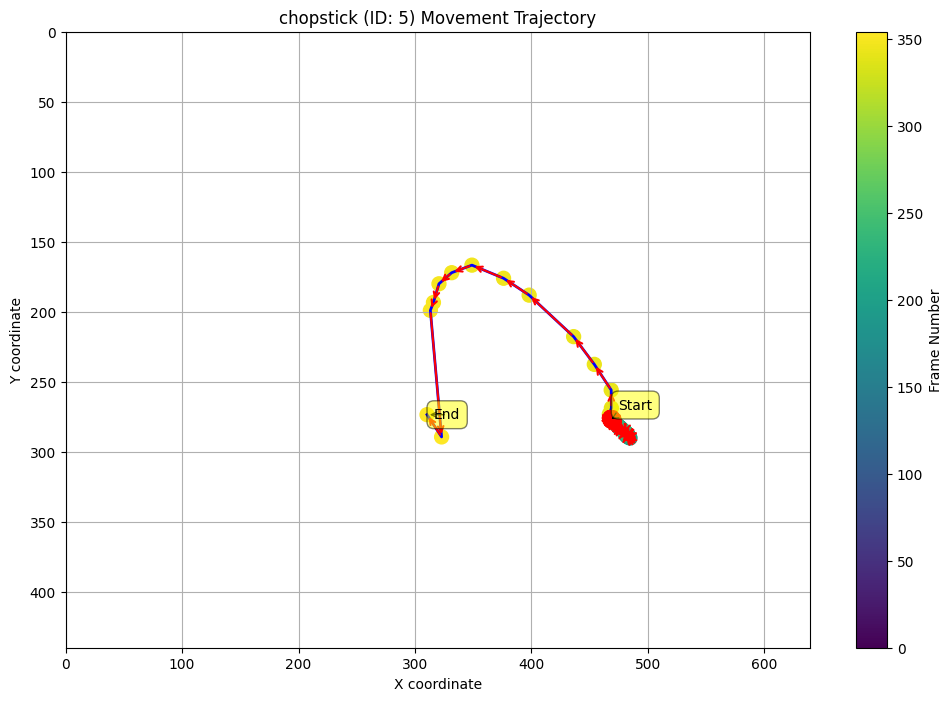

Movement detected from frame 339 to frame 353

Movement summary for Object 5:
From frame 0 to 1: Moved 0.37 pixels
  Primarily downward movement
From frame 1 to 2: Moved 0.61 pixels
  Primarily rightward movement
From frame 2 to 3: Moved 0.10 pixels
  Primarily leftward movement
From frame 3 to 4: Moved 0.13 pixels
  Primarily leftward movement
From frame 4 to 5: Moved 0.09 pixels
  Primarily downward movement
From frame 5 to 6: Moved 0.22 pixels
  Primarily upward movement
From frame 6 to 7: Moved 0.06 pixels
  Primarily rightward movement
From frame 7 to 8: Moved 0.11 pixels
  Primarily leftward movement
From frame 8 to 9: Moved 0.12 pixels
  Primarily rightward movement
From frame 9 to 10: Moved 0.11 pixels
  Primarily leftward movement
From frame 10 to 11: Moved 0.07 pixels
  Primarily rightward movement
From frame 11 to 12: Moved 0.05 pixels
  Primarily rightward movement
From frame 12 to 13: Moved 0.10 pixels
  Primarily upward movement
From frame 13 to 14: Moved 0.10 pixels
  Pr

In [80]:
obj_id=5
object_coords = {}
for frame in sorted(mask_coordinates.keys()):
    if obj_id in mask_coordinates[frame]:
        centroid = get_centroid(mask_coordinates[frame][obj_id])
        if centroid is not None:
            object_coords[frame] = centroid

if not object_coords:
    print(f"No valid coordinates for Object {obj_id}")

# Extract x and y coordinates
frames = list(object_coords.keys())
y_coords = [coord[0] for coord in object_coords.values()]
x_coords = [coord[1] for coord in object_coords.values()]

plt.figure(figsize=(12, 8))

# Plot trajectory
plt.plot(x_coords, y_coords, 'b-', linewidth=2)
plt.scatter(x_coords, y_coords, c=frames, cmap='viridis', s=100)

# Add arrows to show direction
for i in range(1, len(frames)):
    plt.annotate('', xy=(x_coords[i], y_coords[i]), xytext=(x_coords[i-1], y_coords[i-1]),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

# Annotate start and end points
plt.annotate('Start', xy=(x_coords[0], y_coords[0]), xytext=(5, 5), 
                textcoords='offset points', ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.annotate('End', xy=(x_coords[-1], y_coords[-1]), xytext=(5, 5), 
                textcoords='offset points', ha='left', va='top',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.colorbar(label='Frame Number')
plt.title(f'{ID_TO_OBJECTS.get(obj_id, f"Unknown Object")} (ID: {obj_id}) Movement Trajectory')    
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.xlim(0, max_x)
plt.ylim(max_y, 0)  # Invert y-axis to match image coordinates
plt.grid(True)
plt.show()

# Assuming you have lists: x_coords, y_coords
start_frame, end_frame, distances = find_movement_frames(x_coords, y_coords)

if start_frame is not None and end_frame is not None:
    print(f"Movement detected from frame {start_frame} to frame {end_frame}")
else:
    print("No significant movement detected")

print(f"\nMovement summary for Object {obj_id}:")
for i in range(1, len(frames)):
    dx = x_coords[i] - x_coords[i-1]
    dy = y_coords[i] - y_coords[i-1]
    distance = np.sqrt(dx**2 + dy**2)
    print(f"From frame {frames[i-1]} to {frames[i]}: Moved {distance:.2f} pixels")
    if abs(dx) > abs(dy):
        print(f"  Primarily {'rightward' if dx > 0 else 'leftward'} movement")
    else:
        print(f"  Primarily {'downward' if dy > 0 else 'upward'} movement")

# Calculate total distance moved
total_distance = np.sum([np.sqrt((x_coords[i]-x_coords[i-1])**2 + (y_coords[i]-y_coords[i-1])**2) 
                            for i in range(1, len(frames))])
print(f"Total distance moved: {total_distance:.2f} pixels")

In [63]:
print(len(distances))

265


In [56]:
for entry in distances:
    if not entry: 
        print(f"WOOHOO") 
    # print(entry)
    
len(distances)

WOOHOO


265

In [45]:
test =

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2992404755.py, line 1)

In [37]:
mask_coordinates[300]

{1: array([[  0, 249, 256],
        [  0, 249, 257],
        [  0, 249, 258],
        ...,
        [  0, 312, 254],
        [  0, 312, 255],
        [  0, 312, 256]]),
 2: array([[  0, 277, 296],
        [  0, 277, 297],
        [  0, 277, 298],
        ...,
        [  0, 368, 291],
        [  0, 368, 292],
        [  0, 368, 293]]),
 3: array([], dtype=float64),
 4: array([[  0, 277, 209],
        [  0, 277, 210],
        [  0, 277, 211],
        ...,
        [  0, 338, 240],
        [  0, 338, 241],
        [  0, 338, 242]]),
 5: array([[  0, 246, 430],
        [  0, 246, 431],
        [  0, 246, 432],
        ...,
        [  0, 310, 512],
        [  0, 311, 510],
        [  0, 311, 511]]),
 6: array([[  0,   6, 570],
        [  0,   6, 571],
        [  0,   6, 572],
        ...,
        [  0,  45, 564],
        [  0,  45, 565],
        [  0,  45, 566]]),
 7: array([[  0, 309, 338],
        [  0, 309, 339],
        [  0, 309, 340],
        ...,
        [  0, 334, 339],
        [  0, 

In [69]:
import numpy as np

def calculate_distances(x_coords, y_coords):
    distances = np.sqrt(np.diff(x_coords)**2 + np.diff(y_coords)**2)
    return np.insert(distances, 0, 0)  # Add 0 at the beginning for the first frame

def find_movement_frames(x_coords, y_coords):
    distances = calculate_distances(x_coords, y_coords)
    start_frame = None
    end_frame = None
    count_large_movements = 0
    count_small_movements = 0
    last_reset_frame = -1
    
    for idx, distance in enumerate(distances):
        if distance > 5:
            if start_frame is None and idx > last_reset_frame:
                # Find the last distance < 1 before this point, but after the last reset
                for i in range(idx-1, last_reset_frame, -1):
                    if distances[i] < 1:
                        start_frame = i
                        break
                if start_frame is None:
                    start_frame = last_reset_frame + 1  # If no small movement found, set to frame after last reset
            
            count_large_movements += 1
            count_small_movements = 0
        elif distance < 1:
            count_small_movements += 1
            if count_small_movements == 2:
                if count_large_movements >= 5:
                    end_frame = idx - 2  # First frame of the three small movements
                    break
                else:
                    count_large_movements = 0
                    count_small_movements = 0
                    start_frame = None
                    last_reset_frame = idx
        else:
            count_small_movements = 0
    
    # If we found a start frame but no end frame, set end frame to last frame
    if start_frame is not None and end_frame is None:
        end_frame = len(distances) - 1
    
    return start_frame, end_frame, distances


def find_movement_frames(x_coords, y_coords):
    distances = calculate_distances(x_coords, y_coords)
    start_frame = None
    end_frame = None
    count_large_movements = 0
    count_small_movements = 0
    last_reset_frame = -1
    
    for idx, distance in enumerate(distances):
        if distance > 5:
            if start_frame is None and idx > last_reset_frame:
                # Find the last distance < 1 before this point, but after the last reset
                for i in range(idx-1, last_reset_frame, -1):
                    if distances[i] < 1:
                        start_frame = i
                        break
                if start_frame is None:
                    start_frame = last_reset_frame + 1  # If no small movement found, set to frame after last reset
            
            count_large_movements += 1
            count_small_movements = 0
        elif distance < 1:
            count_small_movements += 1
            if count_small_movements == 2:
                if count_large_movements >= 5:
                    end_frame = idx - 1  # First frame of the two small movements
                    break
                else:
                    count_large_movements = 0
                    count_small_movements = 0
                    start_frame = None
                    last_reset_frame = idx
        else:
            count_small_movements = 0
    
    # If we haven't found at least 5 large movements, reset end_frame to None
    if count_large_movements < 5:
        end_frame = None
    
    return start_frame, end_frame, distances


In [46]:

# Assuming you have lists: x_coords, y_coords
start_frame, end_frame = find_movement_frames(x_coords, y_coords)

if start_frame is not None and end_frame is not None:
    print(f"Movement detected from frame {start_frame} to frame {end_frame}")
else:
    print("No significant movement detected")

[0.00000000e+00 4.77834715e-01 9.87308019e-01 7.59574624e-01
 1.67324487e-01 4.85805534e-01 1.30664158e+00 6.92626313e-02
 1.24645186e+01 2.74501660e+01 9.25348930e-01 2.29590925e-01
 3.16883403e+01 5.77432273e+00 5.04565928e+00 7.61749777e-01
 5.59462414e-01 6.94945833e-01 1.75025785e+00 4.82587830e+00
 4.87670446e+00 1.81968862e+00 5.11345614e+00 1.51048854e+00
 9.28587332e-01 2.79405350e+00 2.70266491e+01 6.26930741e+00
 1.79919755e+01 2.95504365e+00 1.32909287e+00 9.90069127e-01
 1.08802454e+00 1.32485430e+00 7.51111637e-01 7.57948689e-01
 9.89969957e-02 5.34479306e-01 2.11609382e+00 4.76749489e+00
 6.61996181e+00 1.31101422e+00 3.38384338e+00 5.13390806e+00
 2.28053989e+00 1.02866617e-01 1.97389077e+00 2.04848713e+00
 2.50653846e+00 1.25313659e+00 3.05219177e+00 3.53816950e+00
 3.03601352e+00 1.15289157e+00 4.84971956e-01 4.40023834e-02
 1.17727689e-01 1.56330682e-01 1.47255442e-01 1.11707425e-01
 1.44902959e-01 2.86600667e-01 1.65176768e-01 2.71116977e-01
 5.79569074e-01 5.671948

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon

# Load the mask coordinates
with open('mask_coordinates.json', 'r') as f:
    mask_coordinates = json.load(f)

# Convert string keys to integers
mask_coordinates = {int(k): {int(k2): np.array(v2) for k2, v2 in v.items()} 
                    for k, v in mask_coordinates.items()}

# Get unique object IDs
object_ids = set(obj_id for frame in mask_coordinates.values() for obj_id in frame)


def get_centroid(coords):
    """Calculate the centroid of the coordinates."""
    if coords.size == 0:  # Handle empty array
        return None
    if coords.ndim == 1:  # Handle 1D array
        return coords[1:] if len(coords) > 2 else None
    return np.mean(coords[:, 1:], axis=0)  # For 2D array, ignore the first column (always 0)

# Determine the original image dimensions
max_y = max_x = 0
for frame in mask_coordinates.values():
    for obj in frame.values():
        if obj.size > 0:
            max_y = max(max_y, np.max(obj[:, 1]))
            max_x = max(max_x, np.max(obj[:, 2]))

def create_mask_image(coords, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    if coords.size > 0:
        coords = coords[:, 1:]  # Remove the first column if it's all zeros
        rr, cc = coords[:, 0], coords[:, 1]
        mask[rr, cc] = 1
    return mask

for obj_id in object_ids:
    object_coords = {}
    for frame in sorted(mask_coordinates.keys()):
        if obj_id in mask_coordinates[frame]:
            centroid = get_centroid(mask_coordinates[frame][obj_id])
            if centroid is not None:
                object_coords[frame] = centroid

    if not object_coords:
        print(f"No valid coordinates for {ID_TO_OBJECTS.get(obj_id, f'Unknown Object')} (ID: {obj_id})")
        continue

    # Extract x and y coordinates
    frames = list(object_coords.keys())
    y_coords = [coord[0] for coord in object_coords.values()]
    x_coords = [coord[1] for coord in object_coords.values()]

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot trajectory on the left subplot
    ax1.plot(x_coords, y_coords, 'b-', linewidth=2)
    scatter = ax1.scatter(x_coords, y_coords, c=frames, cmap='viridis', s=100)
    
    # Add arrows to show direction
    for i in range(1, len(frames)):
        ax1.annotate('', xy=(x_coords[i], y_coords[i]), xytext=(x_coords[i-1], y_coords[i-1]),
                     arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    
    # Annotate start and end points
    ax1.annotate('Start', xy=(x_coords[0], y_coords[0]), xytext=(5, 5), 
                 textcoords='offset points', ha='left', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    ax1.annotate('End', xy=(x_coords[-1], y_coords[-1]), xytext=(5, 5), 
                 textcoords='offset points', ha='left', va='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    plt.colorbar(scatter, ax=ax1, label='Frame Number')
    ax1.set_title(f'{ID_TO_OBJECTS.get(obj_id, "Unknown Object")} (ID: {obj_id}) Movement Trajectory')    
    ax1.set_xlabel('X coordinate')
    ax1.set_ylabel('Y coordinate')
    ax1.set_xlim(0, max_x)
    ax1.set_ylim(max_y, 0)  # Invert y-axis to match image coordinates
    ax1.grid(True)

    # Plot mask evolution on the right subplot
    ax2.set_xlim(0, max_x)
    ax2.set_ylim(max_y, 0)  # Invert y-axis to match image coordinates
    ax2.set_title(f'{ID_TO_OBJECTS.get(obj_id, "Unknown Object")} (ID: {obj_id}) Mask Evolution')
    ax2.set_xlabel('X coordinate')
    ax2.set_ylabel('Y coordinate')

    # Create a colormap that transitions from transparent to solid
    n_frames = len(frames)
    colors = plt.cm.viridis(np.linspace(0, 1, n_frames))
    colors[:, 3] = np.linspace(0.1, 0.8, n_frames)  # Adjust alpha values
    custom_cmap = ListedColormap(colors)

    # Plot masks for each frame
    for i, frame in enumerate(frames):
        coords = mask_coordinates[frame][obj_id]
        mask = create_mask_image(coords, (max_y+1, max_x+1))
        ax2.imshow(mask, cmap=custom_cmap, alpha=mask, vmin=0, vmax=n_frames, extent=[0, max_x, max_y, 0])

    # Add a colorbar for the mask evolution
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=0, vmax=n_frames-1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax2, label='Frame Progression')
    cbar.set_ticks([0, n_frames-1])
    cbar.set_ticklabels([f'Frame {frames[0]}', f'Frame {frames[-1]}'])

    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\nMovement and mask evolution summary for {ID_TO_OBJECTS.get(obj_id, 'Unknown Object')} (ID: {obj_id}):")
    print(f"First appearance: Frame {frames[0]}")
    print(f"Last appearance: Frame {frames[-1]}")
    print(f"Total frames: {len(frames)}")

    # Calculate total distance moved
    total_distance = np.sum([np.sqrt((x_coords[i]-x_coords[i-1])**2 + (y_coords[i]-y_coords[i-1])**2) 
                             for i in range(1, len(frames))])
    print(f"Total distance moved: {total_distance:.2f} pixels")

    # # Uncomment these lines if you want detailed movement summary
    # for i in range(1, len(frames)):
    #     dx = x_coords[i] - x_coords[i-1]
    #     dy = y_coords[i] - y_coords[i-1]
    #     distance = np.sqrt(dx**2 + dy**2)
    #     print(f"From frame {frames[i-1]} to {frames[i]}: Moved {distance:.2f} pixels")
    #     if abs(dx) > abs(dy):
    #         print(f"  Primarily {'rightward' if dx > 0 else 'leftward'} movement")
    #     else:
    #         print(f"  Primarily {'downward' if dy > 0 else 'upward'} movement")